# Data Munging: Working with Missing Values

In [1]:
import pandas as pd
import os
import numpy as np

In [2]:
train_data_path = os.path.join(os.path.pardir, 'data', 'raw', 'train.csv')
test_data_path = os.path.join(os.path.pardir, 'data', 'raw', 'test.csv')

In [3]:
train_df = pd.read_csv(train_data_path, index_col = 'PassengerId')
test_df = pd.read_csv(test_data_path, index_col = 'PassengerId')

The test and train data are now in two seperate dataframes. In order to fill in the missing values I will first merge them into one data frame. Before merging them I will set the 'survived' attribute in all the test rows to -888. This is so that I can differentiate them from the train rows when I will split them up again at the end.

In [4]:
#Adding a survived row to the test data and giving every row a placeholder value of -888
TEST_PLACEHOLDER = -888
test_df['Survived'] = TEST_PLACEHOLDER 

In [5]:
df = pd.concat([train_df, test_df])

In [6]:
#Check what data is missing with the info() function. You can see that the columns with missing data are Age, Fare, Cabin, and Embarked
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  1309 non-null   int64  
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


### Feature: Embarked

In [7]:
#Extract rows with missing Embarked value
df[df.Embarked.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [8]:
df.Embarked.value_counts() #How many people embarked at different points

S    914
C    270
Q    123
Name: Embarked, dtype: int64

By looking at the value counts, you can see that the majoriy of people emarked at 'S' so you could just add 'S' in the missing values. You can also see how the embarkment point correlates with other values and see which embarked point is most likely based on other data. I can't be bothered writing out the code now so I'll just add 'C' for now. This is as embarkment point is correlated with passenger class, and the passengers with unkown embarked points werre both in 1st class, which correlates highly with embarkment point 'C'.

In [9]:
df.Embarked.fillna('C', inplace = True)

### Feature: Fare

In [10]:
df[df.Fare.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1044,-888,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [11]:
# I will assumen the Fare value is the median value of fares paid by 3rd class passengers embarking at S
median_fare = df.loc[(df.Embarked == 'S') & (df.Pclass == 3), 'Fare'].median()
df.Fare.fillna(median_fare, inplace = True)

### Feature: Age

The best way to estimate the Age is by the passenger's title. The data downs't have a row for title, but we can extract it from their name and add one ourselves.

In [12]:
#Extracting title from name
def getTitle(name):
    title = name.split(',')[1].split('.')[0]
    return title.lower().strip()

In [13]:
df['Title'] = df.Name.map(lambda x: getTitle(x)) #using 'map' function. Maps data in a series according to an input function

In [14]:
# median age seems to vary a lot with title, so I will use that to guess the Age
df[df.Age.notnull()].groupby('Title').Age.median()

Title
capt            70.0
col             54.5
don             40.0
dona            39.0
dr              49.0
jonkheer        38.0
lady            48.0
major           48.5
master           4.0
miss            22.0
mlle            24.0
mme             24.0
mr              29.0
mrs             35.5
ms              28.0
rev             41.5
sir             49.0
the countess    33.0
Name: Age, dtype: float64

In [15]:
median_title_age = df.groupby('Title').Age.transform('median') # essentially a dictionary of rows with the age transformed with the median age for the title
df.Age.fillna(median_title_age, inplace = True)

### Feature: Cabin

There are too many missing values for the Cabin column so we will not use this in our model

# Data Munging: Working with outliers

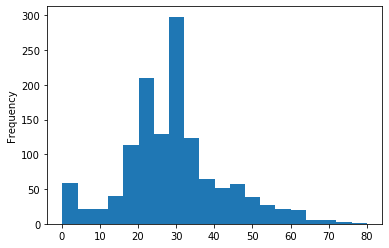

In [16]:
df.Age.plot(kind='hist', bins = 20)

In [17]:
# exploring the outliers. They seem normal
df[df.Age > 70]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C,mr
117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,mr
494,0,1,"Artagaveytia, Mr. Ramon",male,71.0,0,0,PC 17609,49.5042,NaN,C,mr
631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,A23,S,mr
852,0,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.7750,NaN,S,mr
988,-888,1,"Cavendish, Mrs. Tyrell William (Julia Florence...",female,76.0,1,0,19877,78.8500,C46,S,mrs


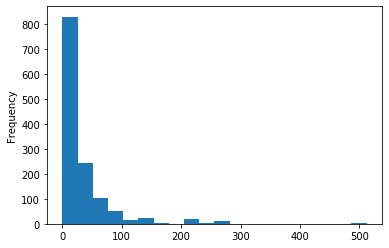

In [18]:
# seeing if there are any outliers in the fare attribute. Looks like there is one
df.Fare.plot(kind = 'hist', bins = 20)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,miss
680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,mr
738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C,mr
1235,-888,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.0,0,1,PC 17755,512.3292,B51 B53 B55,C,mrs


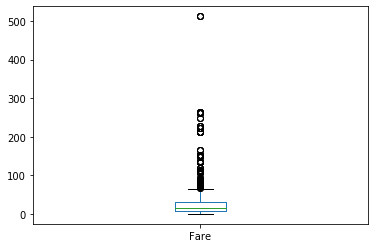

In [19]:
df.Fare.plot(kind = 'box')
df[df.Fare == df.Fare.max()]

## Binning
Putting data points into bins, essentially quantising the. I will split the Fare values into 4 bins, very_low, low, high, very_high. This is to lessen the impact of the outliers

In [20]:
pd.qcut(df.Fare, 4) #splits the fare values into four bins. Each bin will have the same number of data points

PassengerId
1         (-0.001, 7.896]
2       (31.275, 512.329]
3         (7.896, 14.454]
4       (31.275, 512.329]
5         (7.896, 14.454]
              ...        
1305      (7.896, 14.454]
1306    (31.275, 512.329]
1307      (-0.001, 7.896]
1308      (7.896, 14.454]
1309     (14.454, 31.275]
Name: Fare, Length: 1309, dtype: category
Categories (4, interval[float64]): [(-0.001, 7.896] < (7.896, 14.454] < (14.454, 31.275] < (31.275, 512.329]]

In [21]:
pd.qcut(df.Fare, 4, labels = ['very_low', 'low', 'high', 'very_high']).value_counts()

very_low     337
high         328
very_high    323
low          321
Name: Fare, dtype: int64

In [22]:
#create bin fare feature
df['Fare_Bin'] = pd.qcut(df.Fare, 4, labels = ['very_low', 'low', 'high', 'very_high'])

# Feature Engineering

## Feature: Age State (Adult or Child)
This feature is being created as children may have had priority to the lifeboats, so this will be a useful feature for predicting survival.


In [23]:
#using 'where' numpy function
df['Age_State'] = np.where(df['Age'] >= 18, 'Adult', 'Child')

In [24]:
df['Age_State'].value_counts()

Adult    1147
Child     162
Name: Age_State, dtype: int64

In [25]:
# comparing survival rates between adults and children
pd.crosstab(df[df.Survived != TEST_PLACEHOLDER].Survived, df[df.Survived != TEST_PLACEHOLDER].Age_State)

Age_State,Adult,Child
Survived,,
0,495,54
1,279,63


In [26]:
df['Family_Size'] = df.Parch + df.SibSp + 1

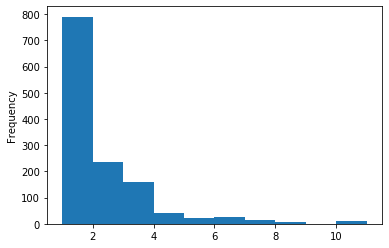

In [27]:
# explore the family feature
df['Family_Size'].plot(kind = 'hist')

In [28]:
# explore the family feature
df.loc[df.Family_Size == df.Family_Size.max()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Fare_Bin,Age_State,Family_Size
PassengerId,,,,,,,,,,,,,,,
160,0,3,"Sage, Master. Thomas Henry",male,4.0,8,2,CA. 2343,69.55,NaN,S,master,very_high,Child,11
181,0,3,"Sage, Miss. Constance Gladys",female,22.0,8,2,CA. 2343,69.55,NaN,S,miss,very_high,Adult,11
202,0,3,"Sage, Mr. Frederick",male,29.0,8,2,CA. 2343,69.55,NaN,S,mr,very_high,Adult,11
325,0,3,"Sage, Mr. George John Jr",male,29.0,8,2,CA. 2343,69.55,NaN,S,mr,very_high,Adult,11
793,0,3,"Sage, Miss. Stella Anna",female,22.0,8,2,CA. 2343,69.55,NaN,S,miss,very_high,Adult,11
847,0,3,"Sage, Mr. Douglas Bullen",male,29.0,8,2,CA. 2343,69.55,NaN,S,mr,very_high,Adult,11
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,22.0,8,2,CA. 2343,69.55,NaN,S,miss,very_high,Adult,11
1080,-888,3,"Sage, Miss. Ada",female,22.0,8,2,CA. 2343,69.55,NaN,S,miss,very_high,Adult,11
1234,-888,3,"Sage, Mr. John George",male,29.0,1,9,CA. 2343,69.55,NaN,S,mr,very_high,Adult,11


In [29]:
# See how family size correlates to survived
pd.crosstab(df[df.Survived != TEST_PLACEHOLDER].Survived, df[df.Survived != TEST_PLACEHOLDER].Family_Size)

Family_Size,1,2,3,4,5,6,7,8,11
Survived,,,,,,,,,
0,374,72,43,8,12,19,8,6,7
1,163,89,59,21,3,3,4,0,0


## Feature: IsMother

Whether the passenger is a mother may have an impact on survival. The IsMother feature will be 1 ot the passenger wa a mother, and 0 if the passneger was not. I will assume that the passenger was a mother if they are female, are over 18, the number of parents or children is greater than 0, and their title is not 'miss'. 
The 'Parch' feature is the number of parents and children that the passneger had on board. I'm not sure why it diesn't make the distinction between parents and children, so we have to make our own feature.

In [30]:
condition = (df.Sex == 'female') & (df.Age_State == 'Adult') & (df.Parch > 0) & (df.Title !='miss') & (df.Title != 'mlle')
df['IsMother'] = np.where(condition, 1, 0)

# explore this feature
df_test = df[df.Survived != TEST_PLACEHOLDER]
pd.crosstab(df_test.Survived, df_test.IsMother)

IsMother,0,1
Survived,,
0,533,16
1,302,40


## Feature: Deck

The deck is where on the ship the cabin in located. We will get this information be taking the letter from the cabin feature.

In [31]:
df.Cabin.unique() #unique cabin values in the dataset

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [32]:
# create a functin to extract the first letter of the cabin
def get_deck(cabin):
    return str(cabin)[0]

#using map function to create 'Deck' feature
df['Deck'] = df['Cabin'].map(lambda x : get_deck(x))

In [34]:
# explore this feature
df_test = df[df.Survived != TEST_PLACEHOLDER]
pd.crosstab(df_test.Survived, df_test.Deck) # The deck seems to affect the survivlal rate

Deck,A,B,C,D,E,F,G,T,n
Survived,,,,,,,,,
0,8,12,24,8,8,5,2,1,481
1,7,35,35,25,24,8,2,0,206


# Categorical Feature Encoding
Categorical features need to be encoded so that they can be used for the machine learning algorithm

In [36]:
#sex
df['IsMale'] = np.where(df.Sex == 'male', 1, 0)
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Fare_Bin,Age_State,Family_Size,IsMother,Deck,IsMale
PassengerId,,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,mr,very_low,Adult,2,0,n,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,mrs,very_high,Adult,2,0,C,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,miss,low,Adult,1,0,n,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,mrs,very_high,Adult,2,0,C,0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,mr,low,Adult,1,0,n,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,-888,3,"Spector, Mr. Woolf",male,29.0,0,0,A.5. 3236,8.0500,NaN,S,mr,low,Adult,1,0,n,1
1306,-888,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,dona,very_high,Adult,1,0,C,0
1307,-888,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,mr,very_low,Adult,1,0,n,1


In [44]:
# can use the get_dummies pandas function, which converts categorical features into dummy variables. 
#df = pd.get_dummies(df, columns = ['Deck', 'Pclass', 'Title', 'Fare_Bin', 'Embarked', 'Age_State'])
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Survived            1309 non-null   int64  
 1   Name                1309 non-null   object 
 2   Sex                 1309 non-null   object 
 3   Age                 1309 non-null   float64
 4   SibSp               1309 non-null   int64  
 5   Parch               1309 non-null   int64  
 6   Ticket              1309 non-null   object 
 7   Fare                1309 non-null   float64
 8   Cabin               295 non-null    object 
 9   Family_Size         1309 non-null   int64  
 10  IsMother            1309 non-null   int32  
 11  IsMale              1309 non-null   int32  
 12  Deck_A              1309 non-null   uint8  
 13  Deck_B              1309 non-null   uint8  
 14  Deck_C              1309 non-null   uint8  
 15  Deck_D              1309 non-null   uint8  
 16  Deck_E

# Drop and Re-order columns

We can now remove all the columns we don't need. E.g. we don't need the 'Sex' column anymore because we used it to create the 'IsMale' column. Similarly we don't need the 'Parch' or 'Sibsp' columns as we have created the 'FamilySize' column. Same goes for all the other columns like this.
We will be removing the following columns:
Cabin, Name, Ticket, Parch, SibSp, Sex

In [46]:
#drop columns
df.drop(['Cabin', 'Name', 'Ticket', 'Parch', 'SibSp', 'Sex'], axis = 1, inplace = True)

In [51]:
# reorder columns so that 'Survived' is at the front
columns = [col for col in df.columns if col != 'Survived']
columns = ['Survived'] + columns
df = df[columns]

# Save a dataframe to a file
We have finished the data munging, so now we need to save the dataframe to a file

In [53]:
processed_data_path = os.path.join(os.pardir, 'data', 'processed')
write_test_path = os.path.join(processed_data_path, 'test.csv')
write_train_path = os.path.join(processed_data_path, 'train.csv')

In [59]:
# train data
df[df.Survived != TEST_PLACEHOLDER].to_csv(write_train_path)

#test data. Will need to remove the 'Survived' column
columns = [col for col in df.columns if col != 'Survived']
df.loc[df.Survived == TEST_PLACEHOLDER, columns].to_csv(write_test_path)

In [ ]:
## Building the Data Processing Script